In [324]:
from __future__ import division
import numpy as np
import numpy.ma as nma
from pio import imgio
import apply_mask
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc
from matplotlib import colors as clr
rc('text', usetex=True)
import scipy.ndimage as ndimage
from scipy.optimize import curve_fit
from scipy.signal import correlate2d
from scipy import stats
from lmfit import Model
from pydmd import DMD
from pydmd import FbDMD
from copy import deepcopy
import cv2
import cmap_sunset
from datetime import datetime
%matplotlib inline

In [33]:
path = '/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/'
img_file = path+'plume_30um_dn32_D019/pano/Analysis/pano.img'
W_file = path+'plume_30um_dn32_D019/pano/Analysis/pano.0048.def.U.npz'
U_file = path+'plume_30um_dn32_D019/pano/Analysis/pano.0048.def.W.npz'
instantaneous_mask_file = path+'plume_30um_dn32_D019/pano/Analysis/pano.0048.def.mask.npz'
time_avg_mask_file= path+'plume_30um_dn32_D019/pano/Analysis/pano.0048.def.mask.tave_mask.npz'
Wave_file = path+'plume_30um_dn32_D019/pano/Analysis/pano.0048.def.U.ave.npz'
Wrms_file = path+'plume_30um_dn32_D019/pano/Analysis/pano.0048.def.U.rms.npz'

Uave_file = path+'/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/pano/Analysis/pano.0048.def.U.ave.npz'
Urms_file = path+'/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/plume_30um_dn32_D019/pano/Analysis/pano.0048.def.U.rms.npz'

deltat = 1/500 #s
cal = 3581 #pix/m
D_0 = 1.905e-2 #m
dx = 24
outlet_z_pix = 197

In [34]:
img = imgio.imgio(img_file)

# Liu Model

In [280]:
s

array([   187.2,    188. ,    188.8, ...,  79997.6,  79998.4,  79999.2])

In [284]:
beta_0 = 2e-3 # volume fraction
rho_p = 2500 # kg/m^3
rho_a = 1.225 # kg/m^3
g = 9.81 # m/s^2
w_0 = W_centerline[0]
r_0 = 0.01905 # m
dp = 30e-6 #m
tau_p = 7.4e-3 # s
mu_a = 1.825e-5 # kg m^-1 s^-1


steps = 100000
length = 80000
s = np.arange(0,length,length/steps)
s = s[(s/cal/D_0 > 2.74)]
s_size = np.diff(np.arange(1,length,length/steps))[0]
w_a0 = w_0-(tau_p*g)
r_a0 = r_0
alpha = 0.03
Q_a0 = np.pi*r_a0**2*w_a0
M_a0 = w_a0*Q_a0*rho_a
m_dot = .019 # kg/s


B = (rho_p - rho_a)*np.pi*g*beta_0*w_0*r_0**2
K1 = 15/2*np.pi*beta_0*w_0*r_0**2*rho_a**(-1/3)*mu_a**(2/3)*dp**(-5/3)

In [285]:
steps = len(s)
wp = np.zeros((steps+1,))
wa = np.zeros((steps+1,))
Qa = np.zeros((steps+1,))
Ma = np.zeros((steps+1,))
ra = np.zeros((steps+1,))
beta = np.zeros((steps+1,))

wp[0] = w_0
wa[0] = w_a0
Qa[0] = Q_a0
ra[0] = r_0
Ma[0] = M_a0
beta[0] = beta_0
C = np.zeros((steps+1))
#cs=np.linspace(.1,100,100000)
#Rep = (rho_a*(w_0-w_a0)*dp)/mu_a
#Cd = 24*(1+0.15*Rep**.687)/Rep
#Fd = rho_a*(w_0-w_a0)**2/2*Cd/4*np.pi*dp**2*cs*6*beta_0*w_0*r_0**2/dp**3
#w = wp[0] + s_size/cal * (B-Fd)/(m_dot*wp[0])
#interp_diff = abs(w+np.interp(s[0],(Z[1:-1]),(nma.min(W_plume[1:-1,:],axis=1)/cal/deltat/2)))
#C[0] = cs[np.where(interp_diff==np.min(interp_diff))[0]]
C=1
for i,ii in enumerate(s):
    i=i+1
    ii=ii+s_size
    Rep = (rho_a*abs(wp[i-1]-wa[i-1])*dp)/mu_a
    Cd = 24*(1+0.15*Rep**.687)/Rep
    Fd = rho_a*(wp[i-1]-wa[i-1])**2/2*Cd/4*np.pi*dp**2*C*6*beta_0*w_0*r_0**2/dp**3
    wp[i] = wp[i-1] + s_size/cal * (B-Fd)/(m_dot*wp[i-1])
    Qa[i] = Qa[i-1] + s_size/cal * (2*np.pi*ra[i-1]*abs(wa[i-1])*alpha)
    Ma[i] = Ma[i-1] + s_size/cal * (Fd)/wp[i-1]
    wa[i] = Ma[i]/(Qa[i]*rho_a)
    ra[i] = np.sqrt(Ma[i]/(np.pi*abs(wa[i])))
    Vc_old = (ra[i-1]**2+ra[i-1]*ra[i]*ra[i]**2)
    

# Mean Velocity

In [35]:
W_inst = apply_mask.apply_mask(W_file,instantaneous_mask_file)
W_mean = apply_mask.apply_mask(Wave_file,time_avg_mask_file)

In [36]:
x = np.arange(0+dx, img.ix-dx,dx)
y = np.arange(0+dx,img.iy-dx,dx)
X,Y = np.meshgrid(x,y)

In [12]:
W_inst.shape

(19948, 44, 212)

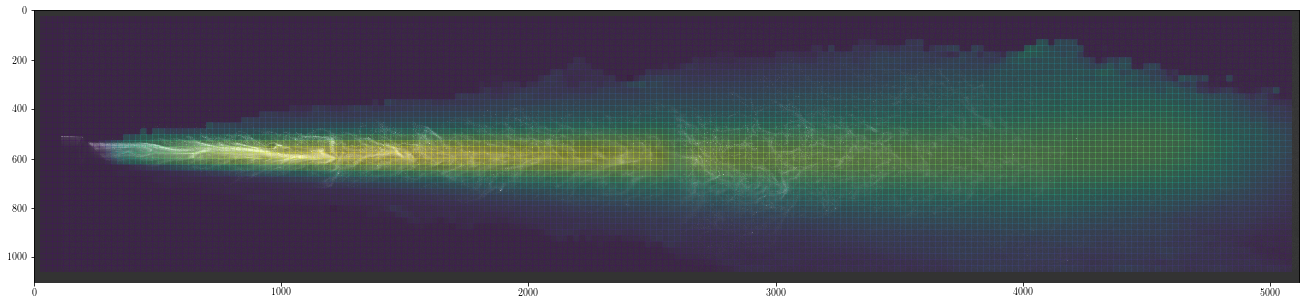

In [385]:
f,ax = plt.subplots(figsize=(5*img.ix/img.iy,5*1))
ax.pcolormesh(X,Y,W_mean.data,alpha=0.3)
ax.imshow(img.read_frame2d(1000),alpha=0.8,cmap=cm.gray)
#ax.set_xlim(0,311)
#ax.set_ylim(1050,1100)

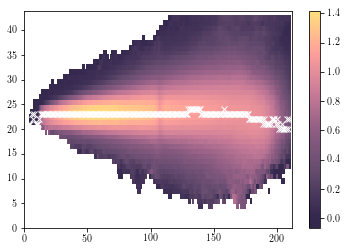

In [37]:
x = np.arange(0+dx, img.ix-dx,dx)
y = np.arange(0+dx,img.iy-dx,dx)
X,Y = np.meshgrid(x,y)
plt.pcolormesh(W_mean/cal/deltat,cmap='sunset')
plt.colorbar()
plt.plot(((centerline[0])),(centerline[1]),'wx')
#plt.xlim(60,120)

In [38]:
mask_zlocs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,103,104,105,106,107,108,109,110,111]
additional_mask = np.load(time_avg_mask_file)['arr_0']
for c in mask_zlocs:
    additional_mask[:,c] = 1
W_mean = nma.masked_array(W_mean, mask=additional_mask)
np.savez_compressed(path+'tave_mask_edited.npz', additional_mask)

In [40]:
centerline = np.zeros((2,W_mean.shape[1]))
for r in range(0,W_mean.shape[1]):
    centerline[0,r] = int(r)#((r*dx+dx+0.5)-outlet_z_pix)
    try:
        centerline[1,r] = int(np.where(W_mean[:,r] == nma.max(W_mean[:,:],axis=0)[r])[0])
    except:
        centerline[1,r] = np.nan
np.savez_compressed(path+'plume_30um_dn32_D019/pano/Analysis/figures/centerline_W.npz',nma.max(W_mean[:,:],axis=0)[~np.isnan(centerline[1])].data/cal/deltat)
centerline = centerline[:,~np.isnan(centerline[1])].astype('int')
np.savez_compressed(path+'plume_30um_dn32_D019/pano/Analysis/figures/centerline_xz_pos.npz',centerline)

In [42]:
W_centerline = np.load(path+'plume_30um_dn32_D019/pano/Analysis/figures/centerline_W.npz')['arr_0']
centerline = np.load(path+'plume_30um_dn32_D019/pano/Analysis/figures/centerline_xz_pos.npz')['arr_0']

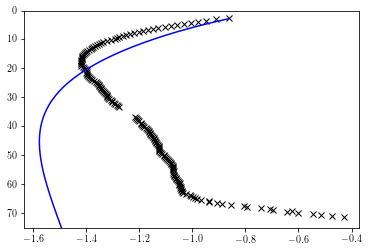

In [286]:
plt.plot(-W_centerline,((centerline[0]*dx+dx+0.5)-outlet_z_pix)/cal/D_0,'kx')
plt.plot(-wp[:-1],s/cal/D_0,'b-')
plt.ylim(75,0);

In [24]:
z_vel_profs = [5,10,18,25,40,50,57,64,70]
d_from_c = (np.arange(0,W_mean.shape[0])-23)*dx/cal/D_0


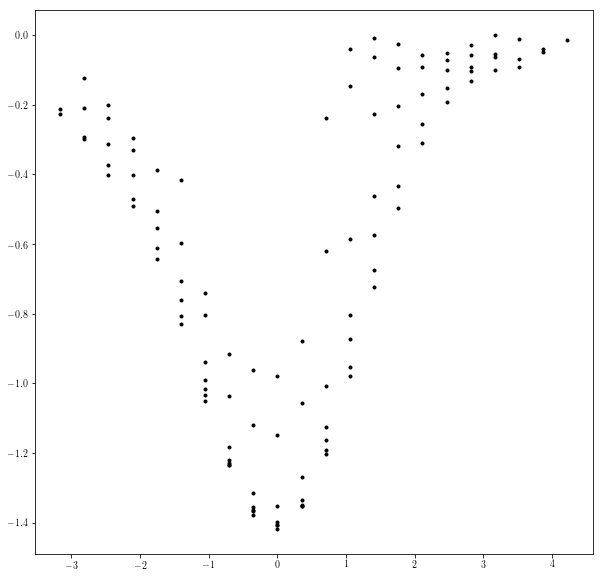

In [45]:
f,ax = plt.subplots(figsize=(10,10))
for z in z_vel_profs:
    ax.plot(d_from_c,-W_mean[:,z]/cal/deltat,'k.')

# Concentration

In [22]:
mean_c = img.read_frame2d(0).astype(int)
for f in range(1,img.it):
    t = img.read_frame2d(f)
    mean_c += t
mean_c = (mean_c / img.it)

In [538]:
len(slices), W_mean.shape[0]*W_mean.shape[1]

(9328, 9328)

In [424]:
c = imgio.imgio('/media/cluster/msi/pet00105/Coletti/Data_2019/Plumes/whole_plume/concentration/dn_58_2in/Raw/pano.avg.img').read_frame2d(0)

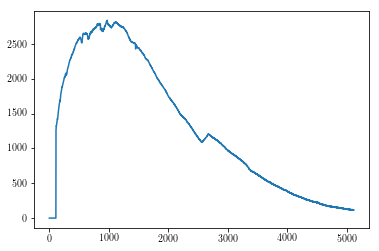

In [425]:
plt.plot(np.mean(c[40:100,:],axis=0))

In [375]:
cc[1]

array([71, 71, 71, ..., 47, 36, 44])

In [381]:
cc[0]

array([ 111,  112,  113, ..., 5117, 5118, 5119])

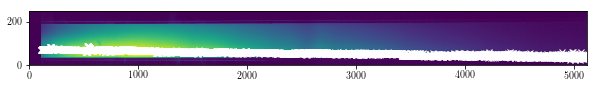

In [413]:
f,ax = plt.subplots(figsize=(10,1))
ax.pcolormesh(c)
ax.plot(cc[0],cc[1],'wx')

In [426]:
cc = np.zeros((2,c.shape[1]))
for r in range(0,c.shape[1]):
    cc[0,r] = int(r)#((r*dx+dx+0.5)-outlet_z_pix)
    try:
        cc[1,r] = int(np.where(c[:,r] == nma.max(c[:,:],axis=0)[r])[0])
    except:
        cc[1,r] = np.nan

In [427]:
cc = cc[:,~np.isnan(cc[1])].astype('int')

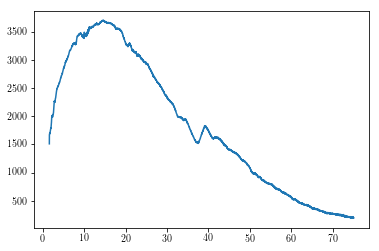

In [416]:
plt.plot(cc[0]/cal/D_0,c[cc[1],cc[0]])

In [428]:
ccc = stats.binned_statistic(cc[0],c[cc[1],cc[0]],bins=4000,statistic='mean')

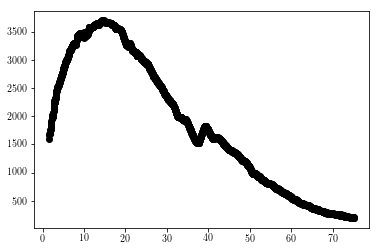

In [421]:
plt.plot(ccc[1][1:]/cal/D_0,ccc[0],'ko')

In [432]:
a2 = np.zeros(len(ccc[0]))
for i in range(0,len(ccc[0])):
    a2[i] = 1.26e-3/c[cc[1],cc[0]][i]

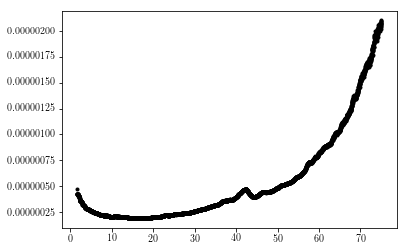

In [436]:
plt.plot(ccc[1][1:]/cal/D_0,a,'k.')

In [405]:
c_map = np.zeros(W_inst.shape)
for f in range(0,W_inst.shape[0]):
    for r in range(int(dx),int(img.iy-(dx)),dx):
        for c in range(int(dx),int(img.ix - (dx)),dx):
            c_map[f,int(r/dx)-1,int(c/dx)-1] = np.mean(img.read_frame2d(f)[slice(r,r+dx,1),slice(c,c+dx,1)])


KeyboardInterrupt: 

In [555]:
n_row_slices = int((img.read_frame2d(0).shape[0]-2*dx)/dx)
n_col_slices = int((img.read_frame2d(0).shape[1]-dx)/dx)
slices = []
for i in x:
    for j in y:
        slices.append((slice(j,j+dx),slice(i,i+dx)))

In [ ]:
c_map = np.zeros(W_inst.shape)
tic = datetime.now()
for f in range(438,W_inst.shape[0]):
    for s in slices:
        c_map[f,int(s[0].start/dx-1),int(s[1].start/dx-1)] = np.mean(img.read_frame2d(f)[s])

In [566]:
t = np.zeros((3,3))
s = [1,2,3,4,5,6,7,8,9]
t = [i for i in s]

SyntaxError: invalid syntax (<ipython-input-566-1499af3d11d5>, line 3)

In [593]:
f

438

In [587]:
int(s[0].start/dx-1),int(s[1].start/dx-1)

(0, 211)

In [ ]:
plt.pcolormesh(c_map[0,:,:],cmap='sunset')
plt.colorbar()

In [397]:
c_bar_w_bar = c_map*W_mean

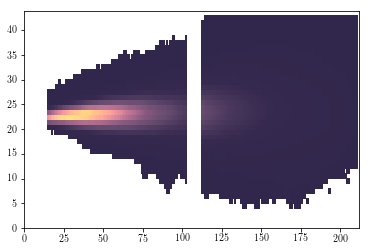

In [398]:
plt.pcolormesh(c_bar_w_bar,cmap='sunset')

In [ ]:
cw = W_inst*c_map
cw_bar = nma.mean(cw,axis=0)
np.savez_compress(path+'figures/avg_mass_flux.npz',cw_bar)

In [401]:
mf = []
for i in range(0,W_mean.shape[1]):
    mf.append(nma.sum(c_bar_w_bar[0:24,i]))

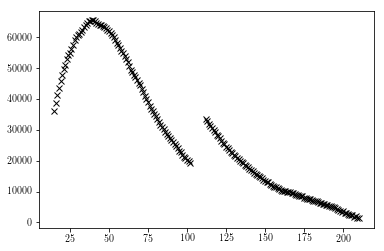

In [402]:
plt.plot(mf,'kx')